In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import detect_plate
import segment_characters
import matplotlib.pyplot as plt
from skimage.io import imshow, imsave
import tempfile
from shared import *

# Extract character images from license plate

<Figure size 1440x864 with 0 Axes>

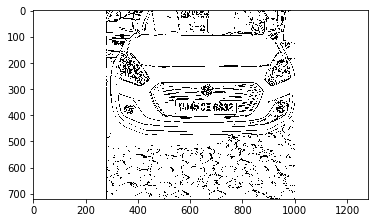

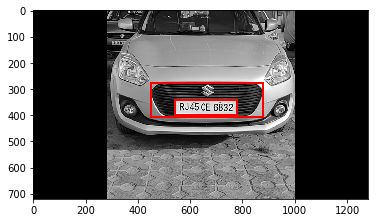

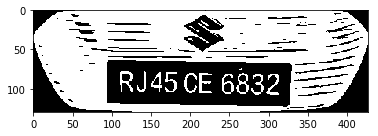

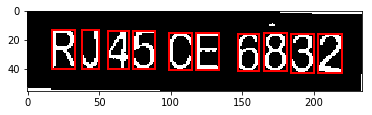

In [3]:
vid_path = 'videos/video1.mp4'

car = detect_plate.CarInput(vid_path)
plate_detector = detect_plate.DetectPlate(car)

plates = []
# look for number plates in the provided video
if plate_detector.areas_of_interest():
    # create a segmenter for the provided input
    seg_char = segment_characters.SegmentCharacters(car.image_for_plate_detection)
    
    # iterate over all areas of interest found in the image
    for area in plate_detector.aoi:
        # get a list of characters found this area of interest
        plate = seg_char.get_cc_from_aoi(area)
        if plate:
            plates.append(plate)  
    if not plates:
        print(err_message['no_lic_plate'])
        raise Exception('No license plate found hence terminating')
else:                        
    print(err_message['no_lic_plate'])
    raise Exception('No license plate found hence terminating')

In [4]:
plates.sort(key=lambda l: len(l), reverse=True)

# Load CNN model and extract license plate number 

It is now time to use the model trained in 'TrainALPR' here

In [5]:
model = load_model('models/ninety_acc_model.hd5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
def char_from_softmax(softmax_vec):
    chars = [chr(ord('0') + i) for i in range(10)] + [chr(ord('A') + i) for i in range(26)]
    mx = np.argmax(softmax_vec)
    confidence = softmax_vec[mx]
    char = chars[mx]
    
    return char, confidence

### Sort the characters according to the position in the license plate

In [7]:
characters = sorted(plates[0], key= lambda x: x.top_left_pixel)

In [8]:
def get_license_number(model, char_list):
    lic_num = []
    for char in char_list:
        tmp = tempfile.TemporaryFile()
        imsave(tmp, char.get_processed_image())
        
        img = image.load_img(tmp, target_size=(30, 30))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = np.vstack([img])
        
        predictions = model.predict(img)
        char, conf = char_from_softmax(predictions[0])
        lic_num.append(char)
        print(f'Character {char} confidence: {conf}')
    
    return ''.join(lic_num)

In [9]:
get_license_number(model, characters)

Character R confidence: 1.0
Character J confidence: 1.0
Character 4 confidence: 1.0
Character 5 confidence: 1.0
Character C confidence: 1.0
Character E confidence: 1.0
Character 6 confidence: 1.0
Character 8 confidence: 1.0
Character 3 confidence: 1.0
Character 2 confidence: 1.0


'RJ45CE6832'